# Camera Callibration


In [64]:
# imports
import os
import sys
import time
import cv2
import requests
import json
import base64
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants
ESP32_CAM1_BASE_URL = 'http://10.1.1.166'
ESP32_CAM2_BASE_URL = 'http://10.1.1.215'

STREAM_ENDPOINT = '/stream'
CONFIG_ENDPOINT = '/config'
CAPTURE_ENDPOINT = '/capture' # not implemented yet

DATA_DIR = os.path.join(os.getcwd(), '../data')
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)


In [36]:
@dataclass
class CameraResolutions:
    QQVGA = 'QQVGA'
    QVGA = 'QVGA'
    VGA = 'VGA'
    SVGA = 'SVGA'
    XGA = 'XGA'
    SXGA = 'SXGA'
    UXGA = 'UXGA'

    @classmethod
    def get_resolutions(cls):
        return [cls.QQVGA, cls.QVGA, cls.VGA, cls.SVGA, cls.XGA, cls.SXGA, cls.UXGA]
    @classmethod
    def get_resolution(cls, resolution):
        if resolution in cls.get_resolutions():
            return resolution
        else:
            raise ValueError(f"Invalid resolution: {resolution}")

@dataclass
class CameraConfig:
    name: str
    ip: str
    resolution: str
    flip_h: int
    flip_v: int

    def __post_init__(self):
        self.url = f"{self.ip}{STREAM_ENDPOINT}"
        if self.resolution not in vars(CameraResolutions).values():
            self.resolution = CameraResolutions.VGA
        self.flip_h = int(self.flip_h)
        self.flip_v = int(self.flip_v)

Camera1 = CameraConfig(
    name='ESP32-CAM1',
    ip=ESP32_CAM1_BASE_URL,
    resolution=CameraResolutions.VGA,
    flip_h=1,
    flip_v=1
)
Camera2 = CameraConfig(
    name='ESP32-CAM2',
    ip=ESP32_CAM2_BASE_URL,
    resolution=CameraResolutions.VGA,
    flip_h=1,
    flip_v=1
)

cameras = []
cameras.append(Camera1)
cameras.append(Camera2)

# 📸 Step 1: Room-Only Frame 
(Calibration Without Human)

In [150]:
# set cameras to init configuration
def set_camera_config(camera, resolution='VGA', flip_h=0, flip_v=0):
    config_url = f"{camera.ip}{CONFIG_ENDPOINT}?resolution={resolution}&flip_h={flip_h}&flip_v={flip_v}"
    try:
        response = requests.get(config_url, timeout=5)
        if response.status_code == 200:
            print(f"{camera.name} configuration set to {resolution} with flip_h={flip_h} and flip_v={flip_v}")
        else:
            print(f"Failed to set camera configuration: {response.status_code}")
    except requests.exceptions.Timeout:
        print(f"Request to {config_url} timed out.")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

for camera in cameras:
    # set_camera_config(camera.ip, camera.resolution, camera.flip_h, camera.flip_v)
    set_camera_config(camera, CameraResolutions.VGA, camera.flip_h, camera.flip_v)

ESP32-CAM1 configuration set to VGA with flip_h=1 and flip_v=1
ESP32-CAM2 configuration set to VGA with flip_h=1 and flip_v=1


In [5]:
# test saving something to data dir
test_image = np.zeros((480, 640, 3), dtype=np.uint8)
test_image.fill(255)  # white image
test_image = cv2.putText(test_image, 'Test Image', (50, 240), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
test_image = cv2.putText(test_image, '🕴️', (250, 240), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
cv2.imwrite(os.path.join(DATA_DIR, 'test_image.jpg'), test_image)

True

## 1.1: Image Capturing Room-Only

In [151]:
# access stream and capture image from ESP32-CAMs

def get_stream(base_url):
    stream_url = base_url + STREAM_ENDPOINT
    try:

        stream = requests.get(stream_url, stream=True)
        if stream.status_code == 200:
            return stream
        else:
            raise Exception(f"Failed to access stream: {stream.status_code}")
    except requests.exceptions.Timeout:
        print(f"Request to {stream_url} timed out.")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
    except Exception as e:
        print(f"[STREAM ]: {e}")

def extract_single_image_from_stream(stream):
    """Extract the first complete JPEG frame from the stream."""
    bytes_buffer = bytes()
    for chunk in stream.iter_content(chunk_size=1024):
        bytes_buffer += chunk
        start = bytes_buffer.find(b'\xff\xd8')  # JPEG start
        end = bytes_buffer.find(b'\xff\xd9')    # JPEG end

        if start != -1 and end != -1:
            jpg = bytes_buffer[start:end+2]
            image = cv2.imdecode(np.frombuffer(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
            return image

    raise RuntimeError("No JPEG frame found in stream.")

def save_extracted_image(image, camera_id, mode='pose'):
    """Save the extracted image locally with a camera identifier."""
    if mode == 'callibration':
        filename = f"{camera_id}_snapshot.jpg"
    else:
        filename = f"{camera_id}_{mode}.jpg"
    filePath = os.path.join(DATA_DIR, filename)
    cv2.imwrite(filePath, image)
    print(f"[✅] Saved snapshot from {camera_id} as {filename}")

def capture_images_from_streams():
    for camera in cameras:
        print(f"[📡] Connecting to {camera.name} stream...")
        stream = get_stream(camera.ip)
        if stream:
            image = extract_single_image_from_stream(stream)
            save_extracted_image(image, camera.name, mode='T-Pose')

time.sleep(10)
capture_images_from_streams()

[📡] Connecting to ESP32-CAM1 stream...
[✅] Saved snapshot from ESP32-CAM1 as ESP32-CAM1_T-Pose.jpg
[📡] Connecting to ESP32-CAM2 stream...
[✅] Saved snapshot from ESP32-CAM2 as ESP32-CAM2_T-Pose.jpg


## 1.2 Desk edge detection

In [ ]:
# use script
# calibrate_desk_corners.py

## 1.3 Desk Properties

In [118]:
origin = np.array([0, 0, 0])

# Desk dimensions (in cm)
object_points = np.array([
    [0, 0, 45],   # Top-right (near couch)
    [0, -55, 45],  # Bottom-right
    [-90, -55, 45],    # Bottom-left
    [-90, 0, 45]      # Top-left
], dtype=np.float32)

# Camera positions (as expected, in cm)
cam1_pos_approx = [100, -216, 210]  # Cam1: 100 cm right of origin, (-(216 - desk_depth)) behind, 210 cm high
cam2_pos_approx = [100,  147, 210]  # Cam2: same X, 147 above desk (in front)
cam1_expected = np.array(cam1_pos_approx)
cam2_expected = np.array(cam2_pos_approx)


## 1.4 Assumption visualization

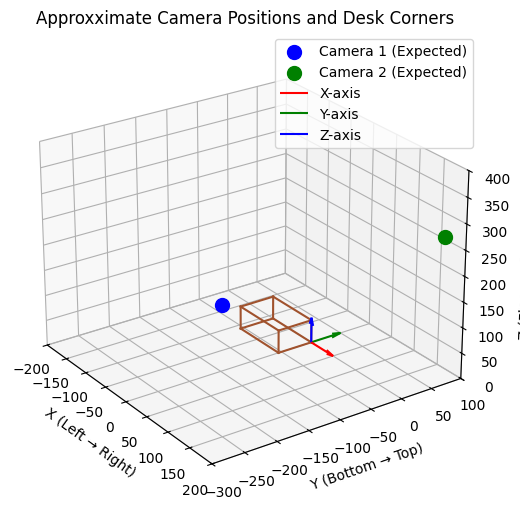

In [84]:

def draw_desk():
    # Define the desk corners (top surface) from top-right origin
    desk_top =object_points.copy()


    # Desk bottom corners (for leg visualization)
    desk_bottom = desk_top.copy()
    desk_bottom[:, 2] = 0  # Z = 0

    # Combine top and bottom for drawing cube
    desk_corners = np.vstack([desk_top, desk_bottom])

    # Define desk edges (12 lines of a cuboid)
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # Top rectangle
        (4, 5), (5, 6), (6, 7), (7, 4),  # Bottom rectangle
        (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical legs
    ]

    # Camera positions (as expected)

    # Plotting
    fig = plt.figure(figsize=(5, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot desk edges
    for i, j in edges:
        xs = [desk_corners[i][0], desk_corners[j][0]]
        ys = [desk_corners[i][1], desk_corners[j][1]]
        zs = [desk_corners[i][2], desk_corners[j][2]]
        ax.plot(xs, ys, zs, color='sienna')

    # Plot camera positions
    ax.scatter(*cam1_expected, color='blue', s=100, label='Camera 1 (Expected)')
    ax.scatter(*cam2_expected, color='green', s=100, label='Camera 2 (Expected)')

    # Draw axis
    origin = np.array([0, 0, 0])
    axis_length = 50
    ax.quiver(*origin, axis_length, 0, 0, color='r', label='X-axis')
    ax.quiver(*origin, 0, axis_length, 0, color='g', label='Y-axis')
    ax.quiver(*origin, 0, 0, axis_length, color='b', label='Z-axis')

    # Label settings
    ax.set_xlabel('X (Left → Right)')
    ax.set_ylabel('Y (Bottom → Top)')
    ax.set_zlabel('Z (Floor → Table)')
    ax.set_title('Approxximate Camera Positions and Desk Corners')
    # make the axes equal in tick length
    ax.set_xlim([-200, 200])
    ax.set_ylim([-300, 100])
    ax.set_zlim([0, 400])
    ax.legend()
    ax.view_init(elev=25, azim=-35)

    plt.tight_layout()
    plt.show()

draw_desk()

## 1.5 Calculate camera positions and rotations

In [108]:
def load_corners(path):
    with open(path, 'r') as f:
        return np.array(json.load(f)['corners'], dtype=np.float32)


In [131]:
def invert_pose(rvec, tvec):
    """Get inverted rotation matrix and camera position in world coordinates."""
    R, _ = cv2.Rodrigues(rvec)
    R_inv = R.T
    t_inv = -R_inv @ tvec
    return R_inv, t_inv


In [126]:
def focal_length_from_fov(image_width, fov_deg=65):
    """Compute focal length in pixels given horizontal FOV and image width."""
    return image_width / (2 * np.tan(np.radians(fov_deg / 2)))

In [129]:
def run_solvepnp(image_points, object_points, image_size, fov_deg=65):
    """Solves for the camera pose given 2D-3D correspondences."""
    h, w = image_size
    fx = fy = focal_length_from_fov(w, fov_deg)
    cx, cy = w / 2, h / 2

    camera_matrix = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
    ], dtype=np.float32)

    dist_coeffs = np.zeros((5, 1))  # no distortion

    success, rvec, tvec = cv2.solvePnP(object_points, image_points, camera_matrix, dist_coeffs)
    if not success:
        raise RuntimeError("solvePnP failed")

    R_inv, tvec_inv = invert_pose(rvec, tvec)

    return rvec, tvec_inv, camera_matrix  # world-aligned camera position
    return rvec, tvec, camera_matrix


In [132]:
def calculate_camera_positions():
    image_size = (1600, 1200)  # VGA or your actual image size

    cam1_image_points = load_corners(DATA_DIR + '/camera_1_corners.json')
    cam2_image_points = load_corners(DATA_DIR + '/camera_2_corners.json')

    rvec1, tvec1, K = run_solvepnp(cam1_image_points, object_points, image_size)
    rvec2, tvec2, _ = run_solvepnp(cam2_image_points, object_points, image_size)

    print("📸 Camera 1 Pose:")
    print("Rotation Vector:\n", rvec1)
    print("Translation Vector:\n", tvec1)

    print("\n📸 Camera 2 Pose:")
    print("Rotation Vector:\n", rvec2)
    print("Translation Vector:\n", tvec2)

    # Optional: save for triangulation
    np.savez(DATA_DIR + "/calibration_extrinsics.npz", rvec1=rvec1, tvec1=tvec1, rvec2=rvec2, tvec2=tvec2, K=K)
    return rvec1, tvec1, rvec2, tvec2, K


In [144]:
rvec1, tvec1, rvec2, tvec2, _ = calculate_camera_positions()
cam1_solvepnp = np.hstack((rvec1, tvec1))
cam2_solvepnp = np.hstack((rvec2, tvec2))

📸 Camera 1 Pose:
Rotation Vector:
 [[ 2.13439875]
 [ 0.99596534]
 [-0.6749597 ]]
Translation Vector:
 [[  67.88344034]
 [-185.28885685]
 [ 189.22814789]]

📸 Camera 2 Pose:
Rotation Vector:
 [[ 0.79471093]
 [ 2.67127422]
 [-1.16321093]]
Translation Vector:
 [[ 75.77939239]
 [ 94.51640671]
 [176.0005829 ]]


## 1.6 Compare Calculations with Assumptions 

Camera 1 (Calculated): [  67.88344034 -185.28885685  189.22814789]
Camera 2 (Calculated): [ 75.77939239  94.51640671 176.0005829 ]


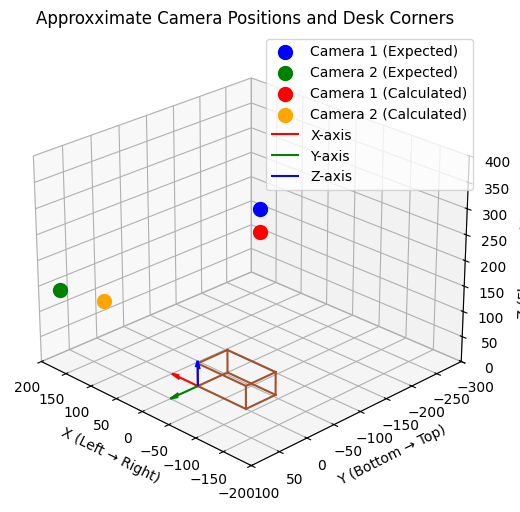

In [141]:
def draw_comparison(tvec1, tvec2):
    # Define the desk corners (top surface) from top-right origin
    desk_top =object_points.copy()


    # Desk bottom corners (for leg visualization)
    desk_bottom = desk_top.copy()
    desk_bottom[:, 2] = 0  # Z = 0

    # Combine top and bottom for drawing cube
    desk_corners = np.vstack([desk_top, desk_bottom])

    # Define desk edges (12 lines of a cuboid)
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # Top rectangle
        (4, 5), (5, 6), (6, 7), (7, 4),  # Bottom rectangle
        (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical legs
    ]



    # Camera positions (calculated)
    cam1_calc = tvec1.flatten()
    cam2_calc = tvec2.flatten()
    print("Camera 1 (Calculated):", cam1_calc)
    print("Camera 2 (Calculated):", cam2_calc)

    # Plotting
    fig = plt.figure(figsize=(5, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot desk edges
    for i, j in edges:
        xs = [desk_corners[i][0], desk_corners[j][0]]
        ys = [desk_corners[i][1], desk_corners[j][1]]
        zs = [desk_corners[i][2], desk_corners[j][2]]
        ax.plot(xs, ys, zs, color='sienna')

    # Plot camera positions
    ax.scatter(*cam1_expected, color='blue', s=100, label='Camera 1 (Expected)')
    ax.scatter(*cam2_expected, color='green', s=100, label='Camera 2 (Expected)')
    ax.scatter(*cam1_calc, color='red', s=100, label='Camera 1 (Calculated)')
    ax.scatter(*cam2_calc, color='orange', s=100, label='Camera 2 (Calculated)')


    # Draw axis
    origin = np.array([0, 0, 0])
    axis_length = 50
    ax.quiver(*origin, axis_length, 0, 0, color='r', label='X-axis')
    ax.quiver(*origin, 0, axis_length, 0, color='g', label='Y-axis')
    ax.quiver(*origin, 0, 0, axis_length, color='b', label='Z-axis')

    # Label settings
    ax.set_xlabel('X (Left → Right)')
    ax.set_ylabel('Y (Bottom → Top)')
    ax.set_zlabel('Z (Floor → Table)')
    ax.set_title('Approxximate Camera Positions and Desk Corners')
    # make the axes equal in tick length
    ax.set_xlim([-200, 200])
    ax.set_ylim([-300, 100])
    ax.set_zlim([0, 400])
    ax.legend()
    ax.view_init(elev=25, azim=135)

    plt.tight_layout()
    plt.show()

draw_comparison(tvec1, tvec2)

In [134]:
def calculate_error(expected: np.ndarray, calculated: np.ndarray) -> float:
    """Returns total Euclidean distance error in cm."""
    return np.linalg.norm(expected - calculated)

def calculate_errors(cam1_calc: np.ndarray, cam2_calc: np.ndarray):
    error_cam1 = calculate_error(cam1_expected, cam1_calc)
    error_cam2 = calculate_error(cam2_expected, cam2_calc)

    print("🧪 Translation Error Summary:")
    print(f"📸 Camera 1: {error_cam1:.2f} cm")
    print(f"📸 Camera 2: {error_cam2:.2f} cm")

    # Optional: breakdown
    diff1 = cam1_calc - cam1_expected
    diff2 = cam2_calc - cam2_expected
    print(f"  Cam1 Δ: {diff1.round(2)}")
    print(f"  Cam2 Δ: {diff2.round(2)}")



In [136]:
calculate_errors(cam1_solvepnp[:,1], cam2_solvepnp[:,1])


🧪 Translation Error Summary:
📸 Camera 1: 49.05 cm
📸 Camera 2: 67.06 cm
  Cam1 Δ: [-32.12  30.71 -20.77]
  Cam2 Δ: [-24.22 -52.48 -34.  ]


In [142]:
def normalize(vec):
    return vec / np.linalg.norm(vec)

def vector_angle_deg(v1, v2):
    """Returns the angle between two vectors in degrees."""
    cos_theta = np.dot(normalize(v1), normalize(v2))
    cos_theta = np.clip(cos_theta, -1.0, 1.0)  # avoid numerical issues
    angle_rad = np.arccos(cos_theta)
    return np.degrees(angle_rad), cos_theta

def compare_camera_direction_vectors(expected: np.ndarray, calculated: np.ndarray, label=""):
    v_expected = expected - origin
    v_calculated = calculated - origin

    angle, cos_sim = vector_angle_deg(v_expected, v_calculated)

    scale_factor = np.linalg.norm(v_expected) / np.linalg.norm(v_calculated)
    v_calculated_scaled = v_calculated * scale_factor  # Scale to match expected norm
    # error between scaled and expected
    error = np.linalg.norm(v_expected - v_calculated_scaled)

    print(f"📡 {label} Vector Comparison:")
    print(f"  Angle Between Vectors: {angle:.2f}°")
    print(f"  Cosine Similarity: {cos_sim:.4f}")
    print(f"  Expected Vector:   {v_expected.round(2)}")
    print(f"  Calculated Vector: {v_calculated.round(2)}")
    
    print(f"  Scale Factor: {scale_factor:.2f}")
    print(f"  Scaled Calculated Vector: {v_calculated_scaled.round(2)}")
    # error between scaled and expected
    print(f"  Error (scaled): {error:.2f} cm")
    print(f"  Error (original): {np.linalg.norm(v_expected - v_calculated):.2f} cm")
    
    print(f"  Expected Norm:     {np.linalg.norm(v_expected):.2f}")
    print(f"  Calculated Norm:   {np.linalg.norm(v_calculated):.2f}")
    print(f"  Expected Direction: {normalize(v_expected).round(2)}")
    print(f"  Calculated Direction: {normalize(v_calculated).round(2)}")
    print()

    return v_calculated_scaled

# Run the comparison
v_cam1_scaled = compare_camera_direction_vectors(cam1_expected, cam1_solvepnp[:,1], label="Camera 1")
v_cam2_scaled = compare_camera_direction_vectors(cam2_expected, cam2_solvepnp[:,1], label="Camera 2")


📡 Camera 1 Vector Comparison:
  Angle Between Vectors: 4.21°
  Cosine Similarity: 0.9973
  Expected Vector:   [ 100 -216  210]
  Calculated Vector: [  67.88 -185.29  189.23]
  Scale Factor: 1.16
  Scaled Calculated Vector: [  78.81 -215.12  219.7 ]
  Error (scaled): 23.32 cm
  Error (original): 49.05 cm
  Expected Norm:     317.42
  Calculated Norm:   273.40
  Expected Direction: [ 0.32 -0.68  0.66]
  Calculated Direction: [ 0.25 -0.68  0.69]

📡 Camera 2 Vector Comparison:
  Angle Between Vectors: 6.33°
  Cosine Similarity: 0.9939
  Expected Vector:   [100 147 210]
  Calculated Vector: [ 75.78  94.52 176.  ]
  Scale Factor: 1.29
  Scaled Calculated Vector: [ 97.59 121.72 226.65]
  Error (scaled): 30.37 cm
  Error (original): 67.06 cm
  Expected Norm:     275.15
  Calculated Norm:   213.66
  Expected Direction: [0.36 0.53 0.76]
  Calculated Direction: [0.35 0.44 0.82]



Camera 1 (Calculated): [  78.81360943 -215.12291543  219.6964866 ]
Camera 2 (Calculated): [ 97.58759697 121.7168509  226.65098528]


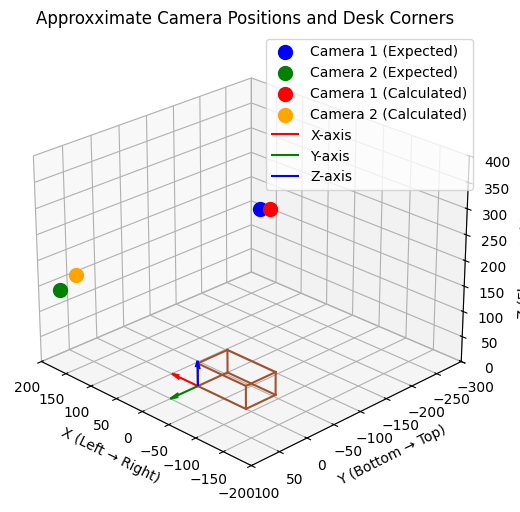

In [143]:
# draw scaled vectors
draw_comparison(v_cam1_scaled, v_cam2_scaled)

## Results

In [ ]:
# First attempt
"""
📡 Camera 1 Vector Comparison:
  Angle Between Vectors: 3.09°
  Cosine Similarity: 0.9985
  Expected Vector:   [ 100 -216  210]
  Calculated Vector: [  83.71 -218.18  214.82]
  Scale Factor: 1.47
  Scaled Calculated Vector: [  83.71 -218.18  214.82]
  Error: 17.13 cm
  Expected Norm:     317.42
  Calculated Norm:   317.42
  Expected Direction: [ 0.32 -0.68  0.66]
  Calculated Direction: [ 0.26 -0.69  0.68]

📡 Camera 2 Vector Comparison:
  Angle Between Vectors: 7.12°
  Cosine Similarity: 0.9923
  Expected Vector:   [100 147 210]
  Calculated Vector: [ 83.25 125.3  230.39]
  Scale Factor: 1.61
  Scaled Calculated Vector: [ 83.25 125.3  230.39]
  Error: 34.16 cm
  Expected Norm:     275.15
  Calculated Norm:   275.15
  Expected Direction: [0.36 0.53 0.76]
  Calculated Direction: [0.3  0.46 0.84]
"""

In [ ]:
# second attempt
"""
📡 Camera 1 Vector Comparison:
  Angle Between Vectors: 4.21°
  Cosine Similarity: 0.9973
  Expected Vector:   [ 100 -216  210]
  Calculated Vector: [  67.88 -185.29  189.23]
  Scale Factor: 1.16
  Scaled Calculated Vector: [  78.81 -215.12  219.7 ]
  Error (scaled): 23.32 cm
  Error (original): 49.05 cm
  Expected Norm:     317.42
  Calculated Norm:   273.40
  Expected Direction: [ 0.32 -0.68  0.66]
  Calculated Direction: [ 0.25 -0.68  0.69]

📡 Camera 2 Vector Comparison:
  Angle Between Vectors: 6.33°
  Cosine Similarity: 0.9939
  Expected Vector:   [100 147 210]
  Calculated Vector: [ 75.78  94.52 176.  ]
  Scale Factor: 1.29
  Scaled Calculated Vector: [ 97.59 121.72 226.65]
  Error (scaled): 30.37 cm
  Error (original): 67.06 cm
  Expected Norm:     275.15
  Calculated Norm:   213.66
  Expected Direction: [0.36 0.53 0.76]
  Calculated Direction: [0.35 0.44 0.82]
"""

## ...

# 🧍‍♂️ Step 2: Human T-Pose Snapshot